# Titanic Survivor Classification Challenge

In this notebook, we're going to be looking at a well known dataset, the Titanic dataset. This dataset contains information about passengers that were aboard the Titanic such as the age, sex, cabin number, name, etc. Our goal is to use these features to predict whether the passenger survived.

Let's get started!

In [1]:
# First import some important libraries.
import os
import warnings
warnings.simplefilter("ignore")

# pandas is a very useful library that lets you manipulate data easily.
import pandas as pd

# numpy is used for doing mathematical operations on arrays
import numpy as np

# matplotlib and seaborn are used to visualize some of the data
import matplotlib.pyplot as plt
import seaborn as sns

## Looking at the data

The data is stored in `./titanic/train.csv`. We can use `pd.read_csv()` to read in our csv file into a pandas DataFrame.

In [2]:
train_file = './titanic/train.csv'

df = pd.read_csv(train_file)
df.head() # Show the first 5 rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
1,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
2,799,0,3,"Ibrahim Shawah, Mr. Yousseff",male,30.0,0,0,2685,7.2292,NaN,C
3,620,0,2,"Gavey, Mr. Lawrence",male,26.0,0,0,31028,10.5000,NaN,S
4,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S


There are 12 columns. Here is the description for each of the columns:

>```
PassengerId      Random ID given to each passenger	
Survived         0 = No, 1 = Yes	
Pclass           Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd	
Sex              Sex	
Age              Age in years	
SibSp            Number of siblings / spouses aboard the Titanic	
Parch            Number of parents / children aboard the Titanic	
Ticket           Ticket number	
Fare             Passenger fare	
Cabin            Cabin number	
Embarked         Port of Embarkation
``` 

We want to predict `Survived` column. Let's try to visualize some of these features:

In [3]:
# Set some styling variables for plots
sns.set_style('whitegrid')
sns.set_palette("muted", 2)

# Define a function to make a bar plot of survivors for each of the categories in the column.
def plot_categorical(x_column, hue_column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    x_column          (str): The column name of a categorical field.
    hue_column        (str): The column name of a second categorical field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(8, 8))
    sns.barplot(x=x_column, y='Survived', hue=hue_column, data=df, errwidth=0)
    plt.title('Survivors separated by {} and {}'.format(x_column, hue_column))
    plt.show()


# Define a function to plot the distribution for survivors and non-survivors for a continuous variable.
def plot_distribution(column, df):
    '''Plot a bar plot for the average survivor rate for different groups.
    column            (str): The column name of a continuous (numeric) field.
    df   (pandas.DataFrame): The pandas DataFrame (just use df here!)
    '''
    fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    #plt.figure(figsize=(8, 8))
    sns.distplot(df[df['Survived'] == 1][column].dropna(), label='Survived')
    sns.distplot(df[df['Survived'] == 0][column].dropna(), label='Did not survive')
    plt.legend()
    plt.title('{} distribution'.format(column))
    plt.show()

<div class="alert alert-block alert-info">
<b>Try this:</b> Use the functions <b>plot_categorical</b> and <b>plot_distribution</b> (defined above) to visualize some of the columns from the data. Some examples are shown below.
</div>

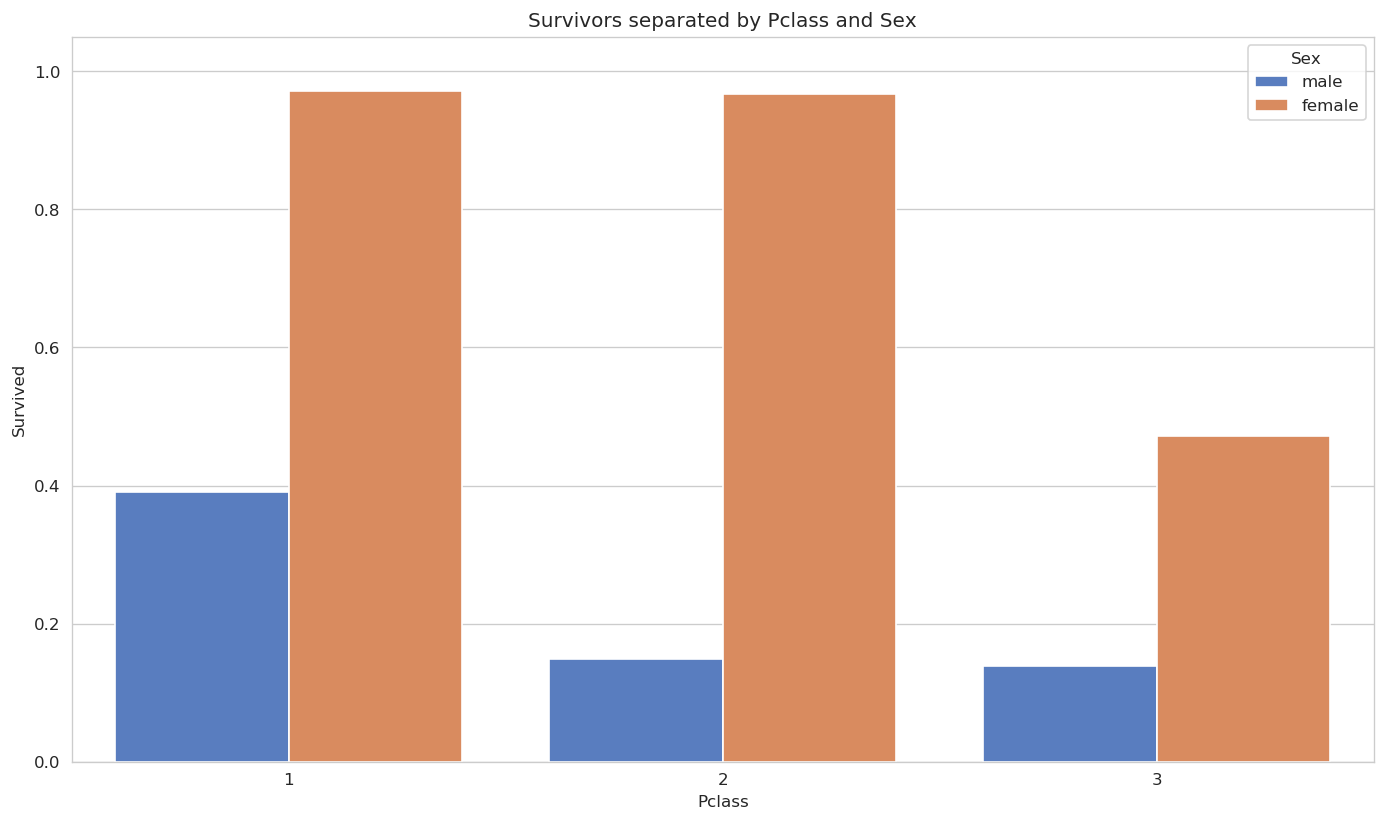

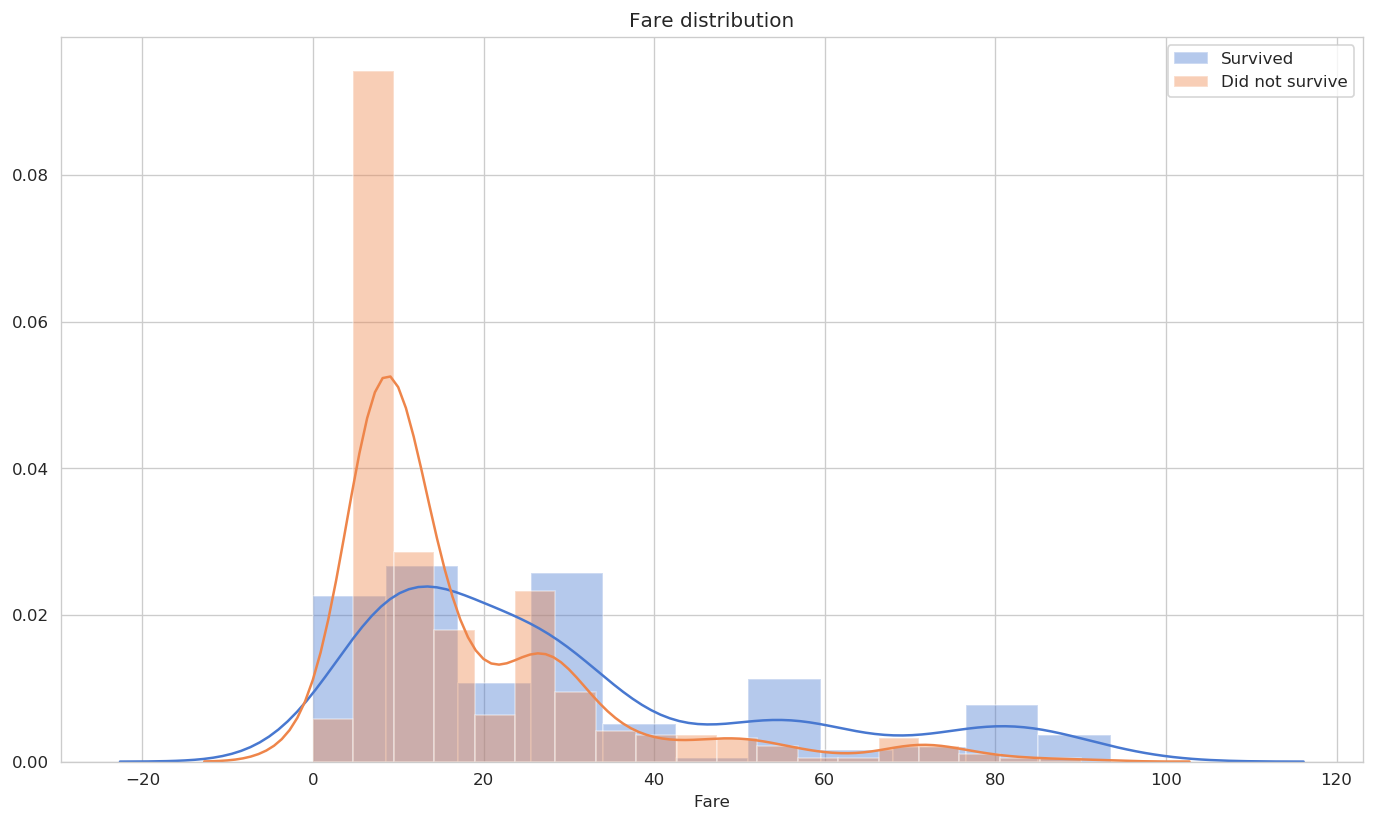

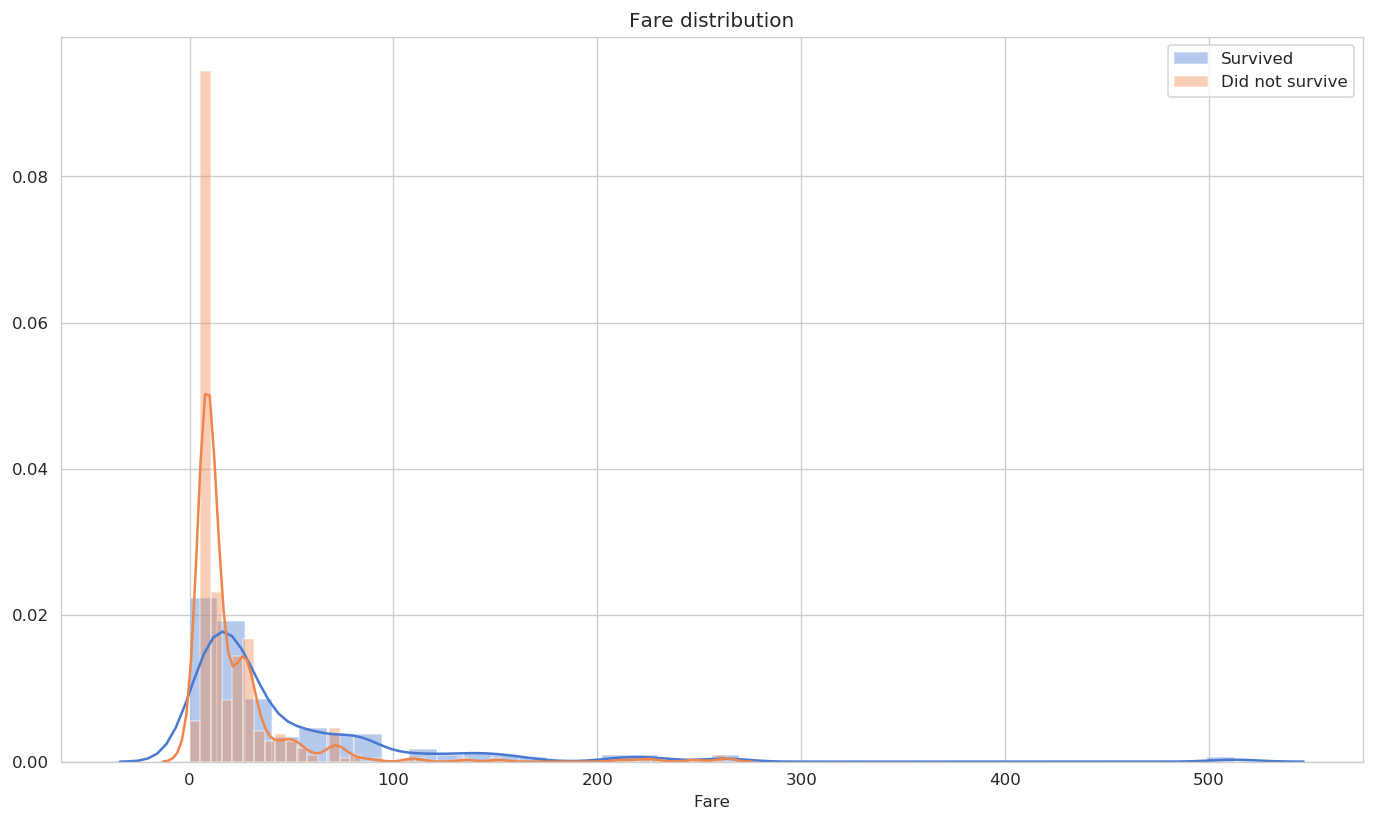

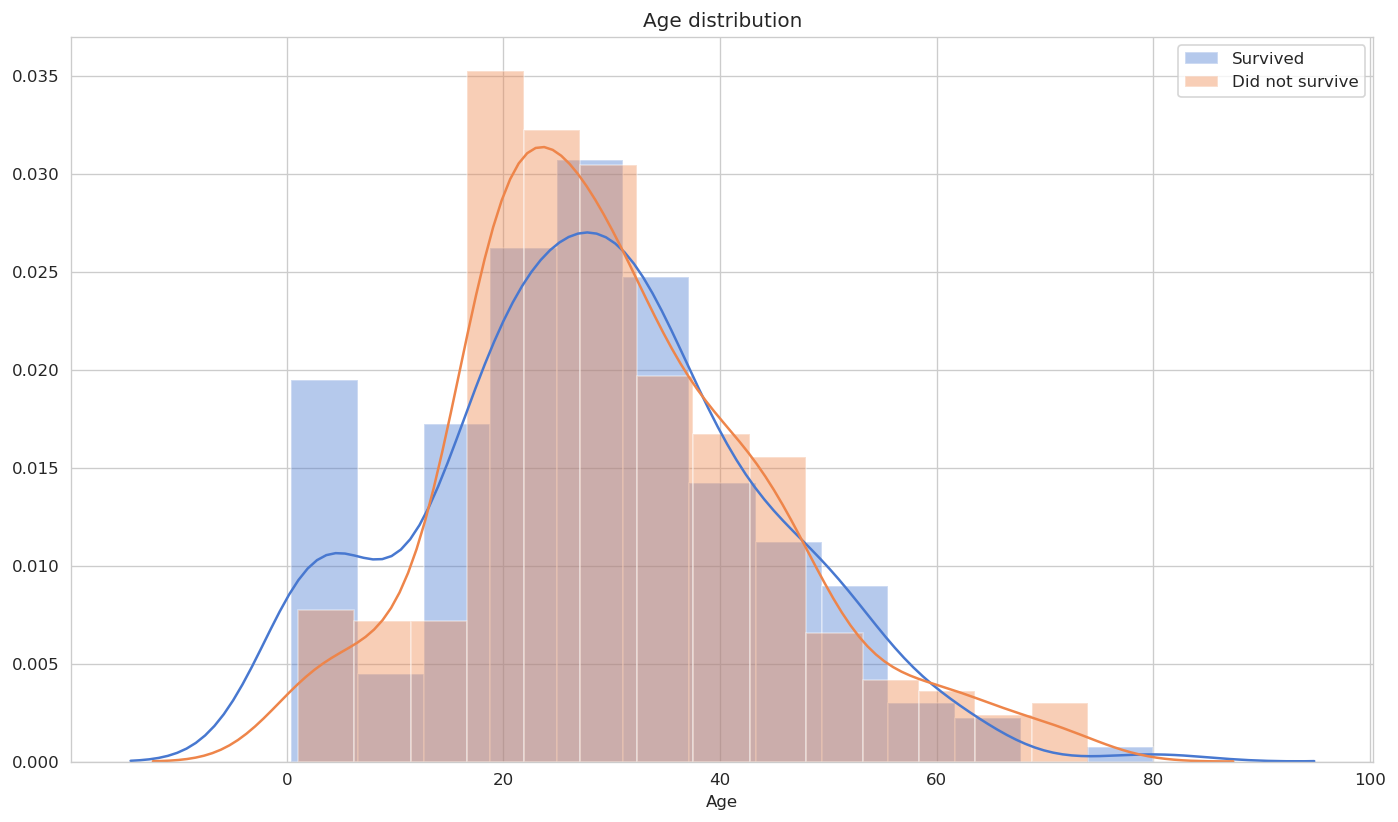

In [8]:
plot_categorical('Pclass', 'Sex', df)
plot_distribution('Fare', df[df['Fare'] < 100]) # df[df['Fare'] < 100] simply removes some outliers!
plot_distribution('Fare', df) # df[df['Fare'] < 100] simply removes some outliers!
plot_distribution('Age', df)

From the visualizations, we can see that more passengers with higher ticket classes survived. Also, women and children survived more often. This makes sense, because women and children were given priority for lifeboats.

Feel free to use the functions above to make plots for the columns you think would be interesting!

## Feature Engineering

Now, we need to choose which features to use, and set up our data to be ready to feed into the model. Let's select out the features we want. For this example, we're going to choose `Pclass`, `Sex`, and `Age`. We also need to keep the `Survived` column, because that's our label.

<div class="alert alert-block alert-info">
<b>Try this:</b> Choose which columns to include in the <b>feature_df</b>. We want to use features that will help us determine whether that person survived. Choosing too many features can lead to a model that's too complex (resulting in overfitting), and choosing too few features can lead to a model that's too simple (resulting in underfitting).
</div>

In [5]:
# We can select columns by indexing the DataFrame with a list of column names.
selected_columns = ['Pclass', 'Sex', 'Age']
feature_df = df[selected_columns + ['Survived']]
feature_df.head()

,Pclass,Sex,Age,Survived
0,3,male,20.0,0
1,3,female,11.0,0
2,3,male,30.0,0
3,2,male,26.0,0
4,3,male,22.0,0


Remember, most of the models we went over can only handle **numerical** data. For our string data in the `Sex` column, we need to encode it with a number. Let's use $0$ to represent male, and $1$ to represent female.

In [6]:
# We can use the map function on a column to map our string values to numerical values.
feature_df['Sex'] = feature_df['Sex'].map({'male': 0, 'female': 1})
feature_df.head()

,Pclass,Sex,Age,Survived
0,3,0,20.0,0
1,3,1,11.0,0
2,3,0,30.0,0
3,2,0,26.0,0
4,3,0,22.0,0


The last thing we need to do before we start applying machine learning alogirthms is to check for missing or `NaN` values.

In [7]:
# This will tell you how many null values there are
feature_df.isna().sum()

Pclass        0
Sex           0
Age         129
Survived      0
dtype: int64

Here, we have 177 missing values for the `Age` column. We can either drop these rows with or try to fill them. In this example, we're going to fill them with the mean.

In [8]:
# We can either drop the rows that have missing values with:
# feature_df.dropna(inplace=True)

# Or, we can fill them with the mean Age:
feature_df.fillna(feature_df['Age'].mean(), inplace=True)
feature_df.isna().sum()

Pclass      0
Sex         0
Age         0
Survived    0
dtype: int64

<div class="alert alert-block alert-info">
<b>Try this:</b> Following the examples above, perform any other feature engineering/data cleaning.
</div>

Now we're done with feature engineering! We want to convert our pandas DataFrame into a NumPy array so we can make our model. `X` will be our features and `y` will be our labels.

In [9]:
# Get numpy array from DataFrame features.
X = feature_df[['Pclass', 'Sex', 'Age']].values
y = feature_df['Survived'].values

## Building a model

We're going to build a classifier to learn to predict whether the passenger survived or not. This is a **binary classification** problem.

Let's use [scikit-learn](https://scikit-learn.org/stable/documentation.html) to run several classification algorithms. In this example, we're going to look at:

- [Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

**Note**: We also use a model selection technique called [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). This is a way to split our data to get multiple validation sets, allowing us to be more confident that our model is good when selecting hyperparameters.

<div class="alert alert-block alert-info">
<b>Try this:</b> Using the templates below, try running different classification algorithms on the data. Tweak the parameters and see which ones work well. Remember to consider **overfitting** and **underfitting** as well as **accuracy**, **recall**, **precision**, and any other metrics.
</div>

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(0) # Set a seed so we can reproduce our results.

### Logistic Regression

In [11]:
lr = LogisticRegression(C=1.0)

# cross_val_score uses 3-fold cross validation to get 3 validation sets. It trains 3 models and evaluates on each of these 3 sets.
# Then, we can look at the scores for each of them. 
cv_score = cross_val_score(lr, X, y, cv=3)

print("Cross validation scores: {:.4f}, {:.4f}, {:.4f}".format(*cv_score))

Cross validation scores: 0.7857, 0.7568, 0.8063


### K-Nearest Neighbors

In [12]:
# Try different values for n_neighbors
knn = KNeighborsClassifier(n_neighbors=5)
cv_score = cross_val_score(knn, X, y, cv=3)

print("Cross validation scores: {:.4f}, {:.4f}, {:.4f}".format(*cv_score))

Cross validation scores: 0.7411, 0.7748, 0.7658


### Naive Bayes

In [13]:
gnb = GaussianNB()
cv_score = cross_val_score(gnb, X, y, cv=3)

print("Cross validation scores: {:.4f}, {:.4f}, {:.4f}".format(*cv_score))

Cross validation scores: 0.7768, 0.6892, 0.8018


### Decision Trees

In [14]:
# Try different values for max_depth and max_leaf_nodes.
dt = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=None)
cv_score = cross_val_score(dt, X, y, cv=3)

print("Cross validation scores: {:.4f}, {:.4f}, {:.4f}".format(*cv_score))

Cross validation scores: 0.7589, 0.8018, 0.7613


### Support Vector Machines

In [15]:
# Try different C values. Also, you may want to try a different kernel such as 'rbf'.
svc = SVC(kernel='linear', C=1.0)
cv_score = cross_val_score(svc, X, y, cv=3)

print("Cross validation scores: {:.4f}, {:.4f}, {:.4f}".format(*cv_score))

Cross validation scores: 0.7768, 0.7838, 0.8018


## Creating a Kaggle submission

It's time to create a Kaggle submission to see how well your model does on the test set. To create your Kaggle submission, choose the best model you found from above to make predictions on the test set. Also, we need to perform the same data preprocessing on the test set that we did on the training set.

<div class="alert alert-block alert-info">
<b>Try this:</b> Perform the same data preprocessing on the test set. A template for the example is given below.
</div>

In [16]:
# Read in the test file
test_file = './titanic/test.csv'
test_df = pd.read_csv(test_file)

# Select the same columns we did for the training set, but without the Survived column
test_feature_df = test_df[selected_columns]
test_feature_df.head()

,Pclass,Sex,Age
0,2,female,30.0
1,1,male,35.0
2,3,male,26.0
3,3,male,NaN
4,1,male,36.0


In [17]:
# Encode our categorical variables
test_feature_df['Sex'] = test_feature_df['Sex'].map({'male': 0, 'female': 1})

# Again, check for null values
test_feature_df.isna().sum()

Pclass     0
Sex        0
Age       48
dtype: int64

In [18]:
# Fill in any null values, and then convert your test_feature_df into a NumPy array
test_feature_df.fillna(test_feature_df['Age'].mean(), inplace=True)

X_test = test_feature_df.values

<div class="alert alert-block alert-info">
Finally, remember to retrain your model with the entire training set. We want to use all of our data, so we won't be splitting our data into cross validation folds for the final predictions.
</div>

In [19]:
# Replace this LogisticRegression(C=1.0) with your own best model!
clf = LogisticRegression(C=1.0)
clf.fit(X, y)
test_predictions = clf.predict(X_test)

This snippet will save your test_predictions in a format that you can submit to Kaggle. The file will be saved as `submission.csv` in the current directory.


In [20]:
test_df['Survived'] = test_predictions
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

All that's left to do is to log onto Kaggle and turn in your submission. Here's a [link](https://www.kaggle.com/t/799729da07794b698a3d3d2179e63958) to the competition

Lastly, here are a couple of other algorithms to try:

- [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)    Uses the adaptive boosting algorithm to train an ensemble of models. AdaBoost usually helps with overfitting and results in a more stable model.

- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) Support vector machines can be computationally intensive, but can be very powerful for both linear and non-linear classification problems.

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) Uses the gradient boosting algorithm to train forest of classifiers. With proper feature engineering XGBoost often wins Kaggle competitions. Requires installation (not part of sklearn).